# Cleaning data with PySpark

## Start spark context

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)
print(sc)
print(sqlContext)

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import types as stypes
from pyspark.sql.functions import udf
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL cleaning data") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as scp
import random
random.seed()

## Posts import

In [4]:
fields = [
    stypes.StructField("Id", stypes.IntegerType(), True),\
    stypes.StructField("PostTypeId", stypes.IntegerType(), True),\
    stypes.StructField("AcceptedAnswerId", stypes.IntegerType(), True),\
    stypes.StructField("ParentId", stypes.IntegerType(), True),\
    stypes.StructField("CreationDate", stypes.StringType(), True),\
    stypes.StructField("DeletionDate", stypes.StringType(), True),\
    stypes.StructField("Score", stypes.IntegerType(), True),\
    stypes.StructField("ViewCount", stypes.IntegerType(), True),\
    stypes.StructField("Body", stypes.StringType(), True),\
    stypes.StructField("OwnerUserId", stypes.IntegerType(), True),\
    stypes.StructField("OwnerDisplayName", stypes.StringType(), True),\
    stypes.StructField("LastEditorUserId", stypes.IntegerType(), True),\
    stypes.StructField("LastEditorDisplayName", stypes.StringType(), True),\
    stypes.StructField("LastEditDate", stypes.StringType(), True),\
    stypes.StructField("LastActivityDate", stypes.StringType(), True),\
    stypes.StructField("Title", stypes.StringType(), True),\
    stypes.StructField("Tags", stypes.StringType(), True),\
    stypes.StructField("AnswerCount", stypes.IntegerType(), True),\
    stypes.StructField("CommentCount", stypes.IntegerType(), True),\
    stypes.StructField("FavoriteCount", stypes.IntegerType(), True),\
    stypes.StructField("ClosedDate", stypes.StringType(), True),\
    stypes.StructField("CommunityOwnedDate", stypes.StringType(), True)
]
customSchema = stypes.StructType(fields)
posts = sqlContext.read\
.format('com.databricks.spark.csv')\
.load("file:///Users/Mat/Google_Drive/tfm/analysis/data/posts_csv",\
      schema=customSchema)

In [5]:
#posts.toPandas()

In [6]:
reduced_posts = posts.drop('ParentId','Score','ViewCount','Body','OwnerDisplayName',\
                         'LastEditorUserId','LastEditorDisplayName','LastEditDate','LastActivityDate','AnswerCount',\
                         'CommentCount','FavoriteCount','CommunityOwnedDate','DeletionDate')

In [7]:
#reduced_posts.describe().toPandas()

## Questions import

### UDF to transform questions columns

In [8]:
parse_time_udf = udf(lambda x: \
    float((datetime.strptime(x.split(".")[0], '%Y-%m-%dT%H:%M:%S') - datetime.min).total_seconds()),\
    stypes.FloatType()
)

parse_time_check_udf = udf(lambda x:\
    float((datetime.strptime(x.split(".")[0], '%Y-%m-%dT%H:%M:%S') - datetime.min).total_seconds())\
    if x is not None else None,\
    stypes.FloatType()
)

tag_counter_udf = udf(lambda x:\
    float(len([tag.split("&lt;")[1] for tag in x.split("&gt;")[0:-1]])),\
    stypes.FloatType()
)

title_length_udf = udf(lambda x:\
    float(len(x)),\
    stypes.FloatType()
)

In [9]:
questions = reduced_posts.filter(reduced_posts.PostTypeId == 1)\
.drop("PostTypeId")
questions = questions.\
withColumn("ParsedCreationDate", parse_time_udf(questions.CreationDate)).\
withColumn("ParsedClosedDate", parse_time_check_udf(questions.ClosedDate)).\
withColumn("TagCount", tag_counter_udf(questions.Tags)).\
withColumn("TitleLength", title_length_udf(questions.Title)).\
withColumnRenamed("OwnerUserId","PosterOwnerUserId").\
drop("CreationDate","ClosedDate", "Tags", "Title")

In [10]:
#questions.toPandas()

In [11]:
#questions.describe().toPandas()

In [12]:
min_time = questions.select(questions.ParsedCreationDate).rdd.min()[0]
print(min_time)

63430377472.0


# Answers import

In [13]:
answers = reduced_posts.filter(reduced_posts.PostTypeId == 2)\
.drop("AcceptedAnswerId", "Title", "Tags", "ClosedDate","PostTypeId")
answers = answers.withColumn("AnsParsedCreationDate", parse_time_udf(answers.CreationDate)).drop(answers.CreationDate)

In [14]:
#answers.describe().toPandas()

In [15]:
answers.registerTempTable("answers")
questions.registerTempTable("questions")

In [16]:
accepted_answers = sqlContext\
.sql("SELECT * FROM answers WHERE answers.Id IN (SELECT AcceptedAnswerId FROM questions)")\

accepted_answers = accepted_answers\
.withColumnRenamed("Id", "AnswerId")\

In [17]:
#accepted_answers.toPandas()

In [18]:
max_time = accepted_answers.select(accepted_answers.AnsParsedCreationDate).rdd.max()[0]
print(max_time)

63592824832.0


## Users import

In [19]:
fields = [
    stypes.StructField("Id", stypes.IntegerType(), True),\
    stypes.StructField("Reputation", stypes.FloatType(), True),\
    stypes.StructField("CreationDate", stypes.StringType(), True),\
    stypes.StructField("DisplayName", stypes.StringType(), True),\
    stypes.StructField("LastAccessDate", stypes.StringType(), True),\
    stypes.StructField("WebsiteUrl", stypes.StringType(), True),\
    stypes.StructField("Location", stypes.StringType(), True),\
    stypes.StructField("AboutMe", stypes.StringType(), True),\
    stypes.StructField("Views", stypes.IntegerType(), True),\
    stypes.StructField("UpVotes", stypes.IntegerType(), True),\
    stypes.StructField("DownVotes", stypes.IntegerType(), True),\
    stypes.StructField("Age", stypes.FloatType(), True),\
    stypes.StructField("AccountId", stypes.IntegerType(), True),\
]
customSchema = stypes.StructType(fields)
users = sqlContext.read\
.format('com.databricks.spark.csv')\
.load("file:///Users/Mat/Google_Drive/tfm/analysis/data/users_csv/part-00000",\
      schema=customSchema)
users.describe().toPandas()
users = users.drop("CreationDate","DisplayName","LastAccessDate","WebsiteUrl","Location","AboutMe","Views","UpVotes",\
                   "DownVotes","AccountId")
users = users.withColumnRenamed("Id","UserId").withColumnRenamed("Reputation","UserReputation")

In [20]:
users.describe().toPandas()

,summary,UserId,UserReputation,Age
0,count,43360,43360,12901
1,mean,31417.359202029522,171.96042435424354,33.28548174560112
2,stddev,19202.403149027137,2012.982474680336,10.22403146691696
3,min,-1,1.0,14.0
4,max,62923,198942.0,96.0


# Join for final dataframe

### First join answers with users

In [21]:
questions_with_users = questions.join(users, questions.PosterOwnerUserId == users.UserId, "left").\
withColumnRenamed("Age","PosterAge").withColumnRenamed("UserReputation","PosterReputation").\
drop("PosterOwnerUserId","UserId")
join_df = questions_with_users.join(accepted_answers, accepted_answers.AnswerId == questions.AcceptedAnswerId, 'full')
join_df = join_df.join(users, join_df.OwnerUserId == users.UserId, "left").\
drop("AcceptedAnswerId","UserId","OwnerUserId", "AnswerId", "Id")

In [22]:
#join_df.toPandas()

In [23]:
join_df.describe().toPandas()

,summary,ParsedCreationDate,ParsedClosedDate,TagCount,TitleLength,PosterReputation,PosterAge,AnsParsedCreationDate,UserReputation,Age
0,count,29301,2511,29301,29301,28727,12214,17917,17208,7763
1,mean,6.3530990516967476E10,6.35485619340693E10,2.0557660148117813,59.35329852223474,12918.052981515648,34.68536106107745,6.352499363107306E10,49932.78074151558,37.24591008630684
2,stddev,4.504117517012715E7,3.532019377350662E7,0.9919622077292334,22.55610271635549,33500.48405203392,11.211497949946038,4.6620306413311735E7,63437.14410370897,9.559868164116324
3,min,6.3430377E10,6.3431139E10,1.0,15.0,1.0,14.0,6.3430377E10,1.0,14.0
4,max,6.3592829E10,6.3592829E10,5.0,168.0,198942.0,96.0,6.3592825E10,198942.0,96.0


## Final formatting and adding censored variable and final time

In [24]:
def final_time(ParsedCreationDate, ParsedClosedDate, AnsParsedCreationDate):

    if(AnsParsedCreationDate):
        return AnsParsedCreationDate-ParsedCreationDate
    elif(ParsedClosedDate):
        return ParsedClosedDate-ParsedCreationDate
    else:
        return max_time-ParsedCreationDate

final_time_udf = udf(final_time, stypes.FloatType())

def censoring_status(ParsedCreationDate, ParsedClosedDate, AnsParsedCreationDate):
    
    if(AnsParsedCreationDate):
        return float(1)
    elif(ParsedClosedDate):
        return float(0)
    else:
        return float(0)
    
censoring_status_udf = udf(censoring_status, stypes.FloatType())

In [25]:
final_df = join_df.\
withColumn("FinalTime",\
final_time_udf(join_df.ParsedCreationDate, join_df.ParsedClosedDate, join_df.AnsParsedCreationDate)).\
withColumn("CensoringStatus",\
censoring_status_udf(join_df.ParsedCreationDate, join_df.ParsedClosedDate, join_df.AnsParsedCreationDate)).\
drop("ParsedCreationDate", "ParsedClosedDate", "AnsParsedCreationDate")

In [26]:
final_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,UserReputation,Age,FinalTime,CensoringStatus
0,count,29301,29301,28727,12214,17208,7763,29301,29301
1,mean,2.0557660148117813,59.35329852223474,12918.052981515648,34.68536106107745,49932.78074151558,37.24591008630684,1.7990164601617694E7,0.6114808368315074
2,stddev,0.9919622077292334,22.55610271635549,33500.48405203392,11.211497949946038,63437.14410370897,9.559868164116324,3.325815829370682E7,0.48742192326517086
3,min,1.0,15.0,1.0,14.0,1.0,14.0,-5.6172544E7,0.0
4,max,5.0,168.0,198942.0,96.0,198942.0,96.0,1.62443264E8,1.0



## Filtering invalid results

In [27]:
final_filtered_df = final_df.filter(final_df.FinalTime > float(0))

In [28]:
final_filtered_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,UserReputation,Age,FinalTime,CensoringStatus
0,count,24009,24009,23517,9683,12425,5554,24009,24009
1,mean,2.058894581198717,59.9233204215086,12649.858017604287,34.83228338324899,46809.372796780684,37.44382427079582,2.195890047365571E7,0.5387146486734141
2,stddev,0.9926152490165466,22.637822393134446,33794.18142702922,11.252678205914636,62553.06355062486,9.477650292365588,3.553240806671485E7,0.4985093045706418
3,min,1.0,15.0,1.0,14.0,1.0,14.0,4096.0,0.0
4,max,5.0,168.0,198942.0,96.0,198942.0,96.0,1.62443264E8,1.0


In [29]:
#final_filtered_df.select("FinalTime","CensoringStatus","TagCount","TitleLength","UserReputation","Age")\
#.toPandas().to_csv("/Users/Mat/Desktop/final_df")

In [30]:
#final_filtered_df.select("FinalTime","CensoringStatus","TagCount","TitleLength","UserReputation","Age").\
#write.csv("/Users/Mat/Desktop/final_df_float")

## Dealing with missing values

Age and UserReputation are data related to the user that posted the answer, and so there are a lot of missing values, as there are numerous not answered questions (censored data). Therefore these features are omited from the survival analysis

In [31]:
final_reduced_df = final_filtered_df.drop("Age","UserReputation")
final_reduced_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
0,count,24009,24009,23517,9683,24009,24009
1,mean,2.058894581198717,59.9233204215086,12649.858017604287,34.83228338324899,2.195890047365571E7,0.5387146486734141
2,stddev,0.9926152490165466,22.637822393134446,33794.18142702922,11.252678205914636,3.553240806671485E7,0.4985093045706418
3,min,1.0,15.0,1.0,14.0,4096.0,0.0
4,max,5.0,168.0,198942.0,96.0,1.62443264E8,1.0


### UDFs to fill NaNs

### Poster Reputation
The feature PosterReputation does not follow any specific distribution, so missing data is imputed randomly.

In [225]:
min_reputation = final_reduced_df.select("PosterReputation").\
where(final_reduced_df.PosterReputation.isNotNull()).rdd.min()[0]
max_reputation = final_reduced_df.select("PosterReputation").\
where(final_reduced_df.PosterReputation.isNotNull()).rdd.max()[0]

In [226]:
final_red_pr_df = final_reduced_df.fillna(random.randint(min_reputation, max_reputation), subset=["PosterReputation"])

In [227]:
final_red_pr_df.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
0,count,24009,24009,24009,9683,24009,24009
1,mean,2.058894581198717,59.9233204215086,12841.525552917656,34.83228338324899,2.195890047365571E7,0.5387146486734141
2,stddev,0.9926152490165466,22.637822393134446,33472.355351248756,11.252678205914636,3.553240806671485E7,0.4985093045706418
3,min,1.0,15.0,1.0,14.0,4096.0,0.0
4,max,5.0,168.0,198942.0,96.0,1.62443264E8,1.0


### Poster Age
The feature PosterAge misses the majority of the data, having only around 40% of the total data. To fill the missing values of this feature, MICE technique has been chosen, using the python package fancyimpute

In [229]:
import fancyimpute

In [232]:
from fancyimpute import MICE, SoftImpute
solver = SoftImpute(verbose=False)

In [254]:
fda = final_red_pr_df.toPandas().as_matrix()

solver = MICE(verbose=0)

fdac = solver.complete(fda) # This works perfectly well.

print(fda)

[[  1.00000000e+00   5.30000000e+01   4.74000000e+02   2.90000000e+01
    2.04800000e+04   1.00000000e+00]
 [  1.00000000e+00   8.50000000e+01   5.84000000e+02   3.10000000e+01
    4.09600000e+03   1.00000000e+00]
 [  3.00000000e+00   4.50000000e+01   3.31100000e+03   3.20000000e+01
    4.09600000e+03   1.00000000e+00]
 ..., 
 [  2.00000000e+00   2.60000000e+01   7.85100000e+03              nan
    1.03559168e+08   1.00000000e+00]
 [  1.00000000e+00   9.00000000e+01   1.24340000e+04              nan
    2.27328000e+06   1.00000000e+00]
 [  1.00000000e+00   4.20000000e+01   1.17700000e+03   2.90000000e+01
    5.03808000e+05   1.00000000e+00]]


In [243]:
full_dums=final_red_pr_df.columns

In [256]:
final_red_pr_df.toPandas().describe()

,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
count,24009.000000,24009.000000,24009.000000,9683.000000,2.400900e+04,24009.000000
mean,2.058895,59.923320,12841.525553,34.832283,2.195890e+07,0.538715
std,0.992615,22.637822,33472.355351,11.252678,3.553241e+07,0.498509
min,1.000000,15.000000,1.000000,14.000000,4.096000e+03,0.000000
25%,1.000000,43.000000,109.000000,27.000000,8.192000e+03,0.000000
50%,2.000000,57.000000,803.000000,33.000000,2.088960e+05,1.000000
75%,3.000000,73.000000,8117.000000,41.000000,3.276390e+07,1.000000
max,5.000000,168.000000,198942.000000,96.000000,1.624433e+08,1.000000


In [255]:
pd_final.describe()

,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
count,24009.000000,24009.000000,24009.000000,24009.000000,2.400900e+04,24009.000000
mean,2.058895,59.923320,12841.525553,34.905050,2.195890e+07,0.538715
std,0.992615,22.637822,33472.355351,7.214057,3.553241e+07,0.498509
min,1.000000,15.000000,1.000000,14.000000,4.096000e+03,0.000000
25%,1.000000,43.000000,109.000000,33.181345,8.192000e+03,0.000000
50%,2.000000,57.000000,803.000000,34.831482,2.088960e+05,1.000000
75%,3.000000,73.000000,8117.000000,36.266765,3.276390e+07,1.000000
max,5.000000,168.000000,198942.000000,96.000000,1.624433e+08,1.000000


In [259]:
prueba = sqlContext.createDataFrame(pd_final)
prueba.describe().toPandas()

,summary,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
0,count,24009,24009,24009,24009,24009,24009
1,mean,2.058894581198717,59.9233204215086,12841.525552917656,34.9050500782497,2.195890047365571E7,0.5387146486734141
2,stddev,0.9926152490165475,22.637822393134428,33472.35535124874,7.214057038582819,3.553240806671484E7,0.49850930457064163
3,min,1.0,15.0,1.0,14.0,4096.0,0.0
4,max,5.0,168.0,198942.0,96.0,1.62443264E8,1.0


In [262]:
pd_final.corr()

,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
TagCount,1.000000,0.060511,-0.014350,0.005192,-0.018741,0.016520
TitleLength,0.060511,1.000000,0.007587,0.072787,0.071873,-0.068567
PosterReputation,-0.014350,0.007587,1.000000,0.214868,-0.003213,0.114674
PosterAge,0.005192,0.072787,0.214868,1.000000,0.083665,-0.014546
FinalTime,-0.018741,0.071873,-0.003213,0.083665,1.000000,-0.599324
CensoringStatus,0.016520,-0.068567,0.114674,-0.014546,-0.599324,1.000000


In [263]:
pd_final.cov()

,TagCount,TitleLength,PosterReputation,PosterAge,FinalTime,CensoringStatus
TagCount,0.985285,1.359731e+00,-4.767656e+02,3.717655e-02,-6.610076e+05,8.174670e-03
TitleLength,1.359731,5.124710e+02,5.749061e+03,1.188693e+01,5.781333e+07,-7.737932e-01
PosterReputation,-476.765584,5.749061e+03,1.120399e+09,5.188446e+04,-3.821557e+09,1.913475e+03
PosterAge,0.037177,1.188693e+01,5.188446e+04,5.204262e+01,2.144613e+07,-5.231089e-02
FinalTime,-661007.593042,5.781333e+07,-3.821557e+09,2.144613e+07,1.262552e+15,-1.061596e+07
CensoringStatus,0.008175,-7.737932e-01,1.913475e+03,-5.231089e-02,-1.061596e+07,2.485115e-01


In [249]:
import pandas
pd_final = pandas.DataFrame(fdac, columns = [x for x in list(final_red_pr_df.columns)])

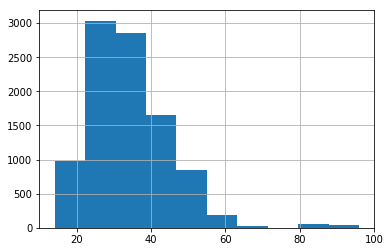

In [252]:
final_red_pr_df.toPandas().PosterAge.hist()

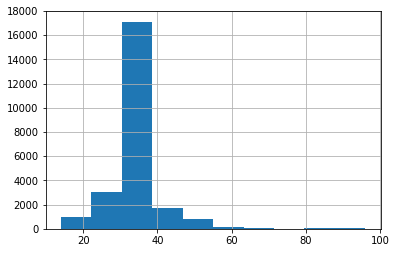

In [251]:
pd_final.PosterAge.hist()